# Trabalho 1 - Modelagem e Avaliação de Desempenho

* Francisco Taam - 119150156
* Felipe Vidal Cantor Bourbon - 119166775
* Lucas Araujo Carvalho - 1191187632
* Lucas Moreno Silva - 11940949
* Pedro Ancelmo de Aquino Vieira Amaral - 119189189

enunciado do trabalho [neste link](https://pt.overleaf.com/project/64fb5c11f463e929e852826d)

Outros links que podem ajudar:

* [Simulador de filas online](https://staff.um.edu.mt/jskl1/simweb/simmm1.html)

* [Vídeo de implementação de fila M/M/1](https://www.youtube.com/watch?v=dpzf2okH_iQ)

* [Vídeo sobre Lei de Little](https://www.youtube.com/watch?v=p1sG7mm1Ixo&)

* [Filas M/M/1 Wikipédia](https://pt.wikipedia.org/wiki/Fila_M/M/1)

* [Intervalo de confiança](https://www.youtube.com/watch?v=lIRBK9MMhrI&list=PLVRCSkl8sA_mmx1J50BCLUkhU46HPgJa2&index=11)

In [1]:
# Imports helpers
from helpers import *
from bisect import bisect_right

## Main Code

In [2]:
# function to properly simulate the queue
def simulate(_lambda, _mu, total_time = 10, total_rounds = 1, queue_size = -1):
  state_time_distribution = {}
  mean_customers_per_round = [] # mean number of customers in the system per round
  mean_wait_time_per_round = [] # mean wait time in the system per round
  mean_empty_state_time_per_round = [] # mean time in which the system was empty per round
  fraction_times_hit_empty_per_round = [] # fraction of times the system hit 0 customers per round
  probability_ruin = 0 # probability of returning to state 0

  # main loop
  for _ in range(total_rounds):
    simulation_queue = Queue() # event queue
    simulation_time = 0 # current time in the simulation
    persons_counter = 0 # number of persons currently in the system
    persons_arrived = 0 # number of persons that arrived in the system
    times_system_empty = 0 # number of times the system hit 0 persons
    events_counter = 0 # number of events treated
    ruined = 0 # flag to check if the system was ruined

    arrival_time = arrival_dist(_lambda) # time of the next arrival
    service_end_time = total_time # time of the next departure
    last_event_time = 0 # time of the last event treated
    area_person_time = 0 # area of the number of persons in the system over time, used to calculate some metrics
    empty_state_time = 0 # amount of time in which the system was empty

    simulation_queue.push((TYPES[0], arrival_time))

    while True:
      event = simulation_queue.pop() # takes the next event from the queue

      # run simulation until an event time exceeds the timeframe
      if event[1] > total_time:
        if persons_counter == 0:
          empty_state_time += total_time - last_event_time
        break

      if event[0] == TYPES[0]:          # if the event is an arrival
        simulation_time = event[1]
        area_person_time += persons_counter * (simulation_time - last_event_time)
        persons_counter += 1
        persons_arrived += 1
        arrival_time = simulation_time + arrival_dist(_lambda)
        simulation_queue.push((TYPES[0], arrival_time))

        if persons_counter == 1:  # if changed from state 0 to 1, push departure and update empty time
          empty_state_time += simulation_time - last_event_time
          service_end_time = simulation_time + departure_dist(_mu)
          simulation_queue.push((TYPES[1], service_end_time))

        if queue_size > 0 and persons_counter > queue_size:
          # buffer overflow, last person that arrived leaves the system
          persons_counter -= 1
          persons_arrived -= 1
          ruined = -1 if ruined == 0 else ruined

      elif event[0] == TYPES[1]:       # if the event is a departure
        simulation_time = event[1]
        area_person_time += persons_counter * (simulation_time - last_event_time)
        persons_counter -= 1

        if persons_counter > 0: # if there are still people in the system, push next departure
          service_end_time = simulation_time + departure_dist(_mu)
          simulation_queue.push((TYPES[1], service_end_time))
        else:                  # if the system became empty, update the number of times it became empty
          ruined = 1 if ruined == 0 else ruined
          times_system_empty += 1

      # no matter which event happens, update the time spent in the state
      time_spent_in_state = simulation_time - last_event_time
      state_time_distribution[persons_counter] = time_spent_in_state if persons_counter not in state_time_distribution \
                                                                      else state_time_distribution[persons_counter] + time_spent_in_state
      
      last_event_time = simulation_time # after treating the event, update last event time
      events_counter += 1 # update the number of events treated

    # store the results of the round into lists
    mean_customers_per_round.append(area_person_time/total_time)
    mean_wait_time_per_round.append(area_person_time/persons_arrived)
    mean_empty_state_time_per_round.append(empty_state_time/total_time)
    fraction_times_hit_empty_per_round.append(times_system_empty/events_counter)
    if ruined == 1:
      probability_ruin += 1
  
  return Statistics(mean_customers_per_round, mean_wait_time_per_round,
                  mean_empty_state_time_per_round, fraction_times_hit_empty_per_round, state_time_distribution, probability_ruin/total_rounds)

In [23]:
LAMBDA = 1
MU = 2
TOTAL_TIME = 1000
TOTAL_ROUNDS = 10
QUEUE_SIZE = 5 # -1 for infinite queue

# Run the simulation
stats = simulate(LAMBDA, MU, TOTAL_TIME, TOTAL_ROUNDS, QUEUE_SIZE)

print(stats)

print(f'Analytic mean customers in system => {littles_law(LAMBDA,MU)}')
print(f'Analytic mean wait time in system => {littles_law(LAMBDA,MU)/LAMBDA}')
print(f'Analytic probability of ruin => {probability_ruin(LAMBDA,MU,QUEUE_SIZE)}')

Mean customers in system    => 0.8842728963336499
Confidence Interval         => [0.8254169393134677, 0.9431288533538321]

Mean wait time in system    => 0.894593339009304
Confidence Interval         => [0.8383955722300896, 0.9507911057885184]

Mean 0 state time in system => 0.5131616156034918
Confidence Interval         => [0.4966664013422684, 0.5296568298647153]

Fraction of times 0 state   => 0.2607331752093996
Confidence Interval         => [0.2491554286591839, 0.2723109217596153]

Probability of ruin         => 1.0

Analytic mean customers in system => 1.0
Analytic mean wait time in system => 1.0
Analytic probability of ruin => 0.967741935483871


### Customer CDF

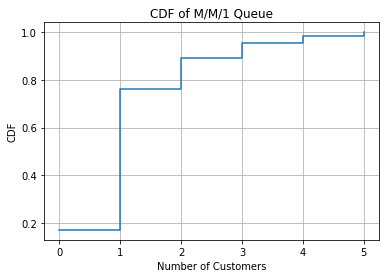

In [4]:
plot_customer_cdf(stats.customer_cdf)

### Wait Time CDF

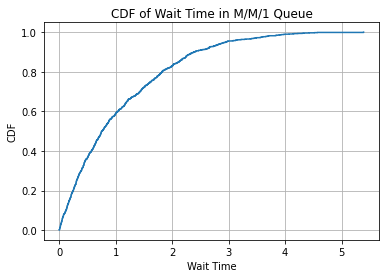

In [5]:
def simulate_cdf(_lambda, _mu, total_time=10, total_rounds=1):
    wait_times = []
    
    for _ in range(total_rounds):
        simulation_queue = Queue()
        wait_time_queue = []  # To store wait times for each customer

        simulation_time = 0
        persons_counter = 0

        arrival_time = arrival_dist(_lambda)
        service_end_time = total_time

        simulation_queue.push(("Arrival", arrival_time))

        while True:
            event = simulation_queue.pop()

            if event[1] > total_time:
                break

            if event[0] == "Arrival":
                simulation_time = event[1]
                persons_counter += 1
                arrival_time = simulation_time + arrival_dist(_lambda)
                simulation_queue.push(("Arrival", arrival_time))

                if persons_counter == 1:
                    service_end_time = simulation_time + departure_dist(_mu)
                    simulation_queue.push(("Departure", service_end_time))
                wait_time_queue.append([simulation_time, 0])  # Arrival time, Wait time placeholder

            elif event[0] == "Departure":
                simulation_time = event[1]
                persons_counter -= 1

                # Calculate wait time for the departed customer
                arrival_time_of_departed_customer, _ = wait_time_queue.pop(0)
                wait_time = simulation_time - arrival_time_of_departed_customer
                wait_times.append(wait_time)

                if persons_counter > 0:
                    service_end_time = simulation_time + departure_dist(_mu)
                    simulation_queue.push(("Departure", service_end_time))

    # Sort wait times to calculate CDF
    sorted_wait_times = sorted(wait_times)
    n = len(sorted_wait_times)
    cdf_wait_times = {x: (bisect_right(sorted_wait_times, x) / n) for x in sorted_wait_times}
    return cdf_wait_times

# Run the simulation to collect wait times and calculate their CDF
wait_time_cdf = simulate_cdf(LAMBDA, MU, TOTAL_TIME, 1)

# Plotting the CDF for wait times
plt.figure()
plt.step(list(wait_time_cdf.keys()), list(wait_time_cdf.values()), where='post')
plt.xlabel('Wait Time')
plt.ylabel('CDF')
plt.title('CDF of Wait Time in M/M/1 Queue')
plt.grid(True)
plt.show()
